In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
pip install Sastrawi

     |████████████████████████████████| 215kB 17.0MB/s 


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
pip install textdistance

In [ ]:
import sys
import pandas as pd
import numpy as np
import re
import math
import os
import textdistance
import itertools
import sqlite3
from heapq import nsmallest
from sklearn.feature_extraction.text import TfidfTransformer
from datetime import date, timedelta
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from collections import Counter
from matplotlib import pyplot
# from translate import Translator
from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))
# from googletrans import Translator

In [ ]:
connection = sqlite3.connect('drive/MyDrive/TA2/muadb2.db')


In [ ]:
result = connection.cursor()
command = "select * from klien"
result.execute(command)
results = result.fetchall()

In [ ]:
MAX = 100000
  
def find3smallest(arr, n): 
    firstmin = MAX
    secmin = MAX
    thirdmin = MAX
    
    first_index, sec_index, third_index = -1,-1,-1
  
    for i in range(0, n): 
          
        # Check if current element 
        # is less than firstmin,  
        # then update first,second 
        # and third 
  
        if arr[i] < firstmin: 
            thirdmin = secmin 
            secmin = firstmin 
            firstmin = arr[i] 
            third_index = sec_index
            sec_index = first_index
            first_index = i
  
        # Check if current element is 
        # less than secmin then update 
        # second and third 
        elif arr[i] < secmin: 
            thirdmin = secmin 
            secmin = arr[i] 
            third_index = sec_index
            sec_index = i
        # Check if current element is 
        # less than,then upadte third 
        elif arr[i] < thirdmin: 
            thirdmin = arr[i] 
            third_index = i
    min_index = [first_index, sec_index, third_index]
    return min_index

In [ ]:
def increasing(data_svm):
    minimum_distances_index =[]
    distances = []
    vocab_all = []
    new_klien = []
    new_service = []
    op=set()
    index_minimum = 0
    for i in (1,2,3,4,5):
        count = data_svm["Label"].loc[data_svm['Label']==i].count()
        if (count<7):
            new_service = []
            data_rating_unproces = data_svm.loc[data_svm["Label"]==i].to_dict("records") #mengubah dataframe menjadi dictionary
            element_count = 7-len(data_rating_unproces)
            for j in range(len(data_rating_unproces)):
                vocab_all = []
                op=set()
                minimum_distancess=[]
                minimum_distances_index =[]
                distances = []
                a = data_rating_unproces[j]
                for k in range(len(data_rating_unproces)):
                    b = data_rating_unproces[k]
                    distance_text = textdistance.cosine.distance(a["Deskripsi"], b["Deskripsi"])
                    if (distance_text==0):
                        distance_text = 1
                    distances.append(distance_text)
                minimum_distancess_index = find3smallest(distances, len(distances))
                n1, n2, n3 = data_rating_unproces[minimum_distancess_index[0]], data_rating_unproces[minimum_distancess_index[1]], data_rating_unproces[minimum_distancess_index[2]]

                for n in (n1,n2,n3):
                    vocab_all = []
                    corpus = [a['Deskripsi'], n['Deskripsi']]
                    for doc in corpus: # iterating through documents in corpus
                        token_temp = doc.split() # create tokens
                        for m in range(len(token_temp)):
                            if token_temp[m] not in vocab_all: # to check if word is already in vocab
                                vocab_all.append(token_temp[m])

                    for l in range(int(len(vocab_all)-2), len(vocab_all)-1):
                        indeks = 0
                        for combination in itertools.combinations(vocab_all, l):
                            if(indeks<element_count):
                                z=" ".join(combination)
                                new_service.append(z)
                                indeks = indeks+1
                            else:
                                break
            result_klien = []

            for value in new_service:
                if value not in result_klien:  
                      result_klien.append(value)
            data_input_temp = pd.DataFrame(columns=['Deskripsi', 'Label'])
            for data in result_klien:
                data_input_temp = pd.DataFrame({"Deskripsi":[data], "Label":[i]})
                data_svm = data_svm.append(data_input_temp, ignore_index = True)       
    return data_svm

In [ ]:
translate_word = pd.read_excel("drive/MyDrive/TA2/translated_term.xlsx")

translate_word_dict = {}

for index, row in translate_word.iterrows():
    if row[0] not in translate_word_dict:
        translate_word_dict[row[0]] = row[1]

def translated_term(document):
    strings = [translate_word_dict[term] if term in translate_word_dict else term for term in document]
    # initialize an empty string 
    str1 = " " 

    # return string   
    return (str1.join(strings))

In [ ]:
normalizad_word = pd.read_csv("drive/MyDrive/TA2/colloquial-indonesian-lexicon.csv")

normalizad_word_dict = {}

for index, row in normalizad_word.iterrows():
    if row[0] not in normalizad_word_dict:
        normalizad_word_dict[row[0]] = row[1]

def normalized_term(document):
    strings = [normalizad_word_dict[term] if term in normalizad_word_dict else term for term in document]
    # initialize an empty string 
    str1 = " " 

    # return string   
    return (str1.join(strings))

In [ ]:
klien_lama = [5,6,9,10,11,17,18,44,28,30,32,33,34,35,37,39,40,41,42,43,29, 14, 25, 21] #User lama 24
klienActive = [1, 24, 36, 38, 31, 23, 29, 14, 25,5,6,9,10,11,17,18,44,21,28,30,32,33,34,35,37,39,40,41,42,43] #30 user
klien_baru = [1, 24, 36, 38, 31, 23]
# kernels = ['rbf', 'sigmoid']
gammas = [0.1, 1, 10, 100]
degrees = [1,2,3,4,5,6]
c = [0.1, 1, 100, 1000]
unrated_old_service = []
cbcf_result = pd.DataFrame(columns=['klien_id','service_id','Value'])
cbcf_old_result = pd.DataFrame(columns=['klien_id','service_id','Value'])

# for i in range(0,5):
#   unrated_old_service = []
  
#   precision_total = 0
#   recall_total = 0
#   f1score_total = 0
#   accuracy_total = 0
#   cbcf_result = pd.DataFrame(columns=['klien_id','service_id','Value'])
#   cbcf_old_result = pd.DataFrame(columns=['klien_id','service_id','Value'])

  # gammas = ['auto']

  #     klienActive_id = 6
  # for klienActive_id in klienActive : 
  #Deklarasi semua data frame yang dibutuhkadn pada proses rating
klienActive_id = 5
# for klienActive_id in klienActive :
#         print(klienActive_id)
#Deklarasi semua data frame yang dibutuhkadn pada proses rating
data_rating = pd.DataFrame(columns=['klien_id', 'service_id', 'Rating'])
data_svm = pd.DataFrame(columns=['Deskripsi','Label'])
data_svm_test = pd.DataFrame(columns=['Deskripsi', 'Label'])
unlabeled_service = pd.DataFrame(columns=['service_id'])
desc_klien = pd.DataFrame(columns=['klien_id', 'Desc'])
#Deklarasi dan inisialisasi proses penghilangan kata yang tidak berguna dalam bahasa indonesia
factory = StopWordRemoverFactory()
stopword = factory.create_stop_word_remover()
factory2 = StemmerFactory()
stemmer = factory2.create_stemmer()
tanggal_sekarang = date.today()
tanggal_3harilalu = date.today() - timedelta(days=2)
#Pengaturan untuk melakukan konversi data menjadi word ccount vector & tf idf
convert = CountVectorizer(strip_accents='ascii', token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b', lowercase=True)
tf_idf = TfidfTransformer()
# translator = Translator(to_lang = 'id')
result_rate=[]
#Melakukukan select data klien yang pernah melakukan rating terhadap service
query_user = connection.cursor()
query_user.execute("select klien_id from rate_to_service group by klien_id order by klien_id")
result_user = query_user.fetchall()
klien_id_lama =[]
for klien_id in result_user:
  klien_id_lama.append(klien_id[0])

for data_user in result_user:
#Melakukan select data hasil rating dari suatu user
    query_rate = connection.cursor()
    query_rate.execute("select service.service_id, (select nilai from rate_to_service tb_rate where tb_rate.service_id=service.service_id and klien_id="+str(data_user[0])+") as nilai, service.deskripsi from service order by service_id")
    result_rate = query_rate.fetchall()
    unlabeled_service.drop(unlabeled_service.index, inplace=True)
    for data_rate in result_rate:
        if data_rate[1] is not None :
            #Memasukkan data rate dari actual rating yang dilakukan suatu user ke suatu service
            dataInput_rating = pd.DataFrame({"klien_id":[data_user[0]], "service_id":[data_rate[0]], "Rating":[data_rate[1]]})
            data_rating = data_rating.append(dataInput_rating, ignore_index = True) 
        else :
            if(data_rate[0] not in (40, 32, 11, 24,9,7,14, 37) and data_user[0] == klienActive_id):
                unrated_old_service.append(data_rate[0])
            #Mengambil service_id yang sama sekali belum pernah dilakukan penilaian baik itu actual rating maupun predicted rating
            input_unlabeled_service = pd.DataFrame({"service_id":[data_rate[0]]})
            unlabeled_service = unlabeled_service.append(input_unlabeled_service, ignore_index = True)

    kondisi_select_in = "";
    row_idx = 1
    for index, row in unlabeled_service.iterrows():
        kondisi_select_in += str(row['service_id'])
        if row_idx < len(unlabeled_service.index):
            kondisi_select_in += ", "
        row_idx += 1

    if kondisi_select_in != "" :
        query_select_in = connection.cursor()
        query_select_in.execute("Select service_id, (service.deskripsi || ' harga = ' || service.harga || ' durasi = ' || service.durasi) as deskripsi from service where service_id in ("+str(kondisi_select_in)+")")
        result_select_in = query_select_in.fetchall()

        #Pengambilan Data Testing untuk SVM
        data_svm_test.drop(data_svm_test.index, inplace=True)
        for data_select_in in result_select_in:
            #Penghilangan karakter-karakter tidak berguna menggunakan fungsi regex
            desc_test_rm_regex = data_select_in[1].replace(r'\r\n', ' ').replace(r'\n', ' ')
            desc_test_rm_regex = re.sub(r'\W', ' ', desc_test_rm_regex)
            
            desc_test_rm_regex = re.sub(r'\s+[a-zA-Z0-9]\s+', ' ', desc_test_rm_regex)
            desc_test_rm_regex = re.sub(r'\^[a-zA-Z0-9]\s+', ' ', desc_test_rm_regex)
            # desc_test_rm_regex = re.sub(r'[^ \w\.]', ' ', desc_test_rm_regex, re.M)
            # desc_test_rm_regex = re.sub(r"^\s+", "", "a\n b\n c", desc_test_rm_regex, flags = re.MULTILINE)
            # desc_test_rm_regex = re.sub(r'\s+\Z', '', desc_test_rm_regex)
            # desc_test_rm_regex = re.sub(r'\s+', ' ', desc_test_rm_regex, flags=re.I)
            
            desc_test_rm_regex = re.sub(r'\s+', ' ', desc_test_rm_regex, flags=re.I)
            desc_test_rm_regex = re.sub(r'^b\s+', ' ', desc_test_rm_regex)
            desc_test_rm_regex = re.sub(r'/(\r\n)+|\r+|\n+/i', ' ', desc_test_rm_regex)
            

            #Penghilangan kata-kata yang tidak berguna dengan bantuan stopword Indonesia & melakukan proses stemming
#             desc_test_rm_regex = translator.translate(desc_test_rm_regex)
            desc_test_rm_regex = desc_test_rm_regex.lower()
            desc_test_rm_regex = translated_term(desc_test_rm_regex.split())
            desc_test_rm_stopword = stopword.remove(desc_test_rm_regex)
            desc_test_rm_stopword = stemmer.stem(desc_test_rm_stopword)
            desc_test_rm_stopword = normalized_term(desc_test_rm_stopword.split())

            input_data_svm_test = pd.DataFrame({"Deskripsi":[desc_test_rm_stopword], "Label":['-1']})
            data_svm_test = data_svm_test.append(input_data_svm_test, ignore_index = True)

        #Melakukan SVM Text Classifier dengan Label Data 0-5
        query_frame_svm = connection.cursor()
        query_frame_svm.execute("select (service.deskripsi || ' harga = ' || service.harga || ' durasi = ' || service.durasi) as deskripsi, nilai from rate_to_service natural join service where klien_id="+str(data_user[0]))
        result_frame_svm = query_frame_svm.fetchall()
        predictions = []

        #Melakukan pengambilan data dari actual rating oleh suatu user yang tersimpan untuk dijadikan data training set
        data_svm.drop(data_svm.index, inplace=True)
        for data_frame_svm in result_frame_svm:
            #Penghilangan karakter-karakter tidak berguna menggunakan fungsi regex
            desc_train_rm_regex = data_frame_svm[0].replace(r'\r\n', ' ').replace(r'\n',' ')
            desc_train_rm_regex = re.sub(r'\W', ' ', desc_train_rm_regex)
            desc_train_rm_regex = re.sub(r'\s+[a-zA-Z0-9]\s+', ' ', desc_train_rm_regex)
            desc_train_rm_regex = re.sub(r'\^[a-zA-Z0-9]\s+', ' ', desc_train_rm_regex)
            # desc_train_rm_regex = re.sub(r'[^ \w\.]', ' ', desc_train_rm_regex, re.M)
            # desc_train_rm_regex = re.sub(r"^\s+", "", "a\n b\n c", desc_train_rm_regex, flags = re.MULTILINE)
            # desc_train_rm_regex = re.sub(r'\s+\Z', ' ', desc_train_rm_regex)
            # desc_train_rm_regex = re.sub(r'\s+', ' ', desc_train_rm_regex, flags=re.I)
            
            desc_train_rm_regex = re.sub(r'\s+', ' ', desc_train_rm_regex, flags=re.I)
            desc_train_rm_regex = re.sub(r'^b\s+', ' ', desc_train_rm_regex)
            # desc_train_rm_regex = re.sub(r'/(\r\n)+|\r+|\n+/i', ' ', desc_train_rm_regex)
            

            #Penghilangan kata-kata yang tidak berguna dengan bantuan stopword Indonesia & melakukan stemming
#             desc_train_rm_regex = translator.translate(desc_train_rm_regex)
            desc_train_rm_regex = desc_train_rm_regex.lower()
            desc_train_rm_regex = translated_term(desc_train_rm_regex.split())
            desc_train_rm_stopword = stopword.remove(desc_train_rm_regex)
            desc_train_rm_stopword = stemmer.stem(desc_train_rm_stopword)
            desc_train_rm_stopword = normalized_term(desc_train_rm_stopword.split())

            dataInput_svm = pd.DataFrame({"Deskripsi":[desc_train_rm_stopword], "Label":[data_frame_svm[1]]})
            data_svm = data_svm.append(dataInput_svm, ignore_index = True)
        data_svm = increasing(data_svm)
        #Melakukan konversi data set Deskripsi, ke dalam word count vector tf idf
        X_train_convert = convert.fit_transform(data_svm['Deskripsi'])
        X_train_tfidf = tf_idf.fit_transform(X_train_convert)
        X_test_convert = convert.transform(data_svm_test['Deskripsi'])
        X_test_tfidf = tf_idf.fit_transform(X_test_convert)
        Y_train = LabelEncoder().fit_transform(data_svm['Label'])
        oversample = SMOTE(k_neighbors=3)
        X_smote, y_smote = oversample.fit_resample(X_train_tfidf, Y_train)
#         counter = Counter(y_smote)
#         for k,v in counter.items():
#             per = v / len(y_smote) * 100
#             print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
#         # plot the distribution
#         pyplot.bar(counter.keys(), counter.values())
#         pyplot.show()

        #Pembuatan model dan melakukan prediksi pada data baru
        param_grid = {'C':[0.1, 1, 100, 1000], 'kernel' : ['rbf', 'linear', 'poly', 'sigmoid'], 'degree': [1,2,3,4,5,6]}
        hasil_model_svm = SVC(kernel='poly', C=0.1, degree = 5)
        hasil_model_svm.fit(X_smote, y_smote)
        hasil_prediksi = hasil_model_svm.predict(X_test_tfidf)

        #Konversi hasil prediksi ke real rating 
        group_label = data_svm.groupby('Label')
        for hasil in hasil_prediksi :
            idx = 0
            for data_label in group_label :
                if str(idx) == str(hasil) :
                    predictions.append(data_label[0])
                idx += 1
#         print('--'+predictions)
        idx_predict = 0
        for data_select_in in result_select_in:
            #Memasukkan ke database hasil prediksi dengan Content Based Recommendation
            # query_insert = connection.cursor()
            # sql = "INSERT INTO rate_prediction (klien_id, service_id, tanggal, nilai, predict_by) VALUES (%s, %s, %s, %s, 'cb_service')"
            # val = (str(data_user[0]), str(data_select_in[0]), str(tanggal_sekarang.strftime("%Y-%m-%d")), str(predictions[idx_predict]))
            # query_insert.execute(sql, val)
            # connection.commit()

            #Memasukkan data rating hasil 
            dataInput_rating = pd.DataFrame({"klien_id":[data_user[0]], "service_id":[data_select_in[0]], "Rating":[predictions[idx_predict]]})
            data_rating = data_rating.append(dataInput_rating, ignore_index = True)

            idx_predict += 1

#Mengecek apakah user aktif yang sedang melakukan training merupakan user baru atau bukan, set status awal adalah user aktif merupakan user baru
status_user_aktif = 1
filter_klien_id = ""
idx_temp = 0
group_klien = data_rating.groupby('klien_id')
for data_klien in group_klien:
    if idx_temp > 0 :
        filter_klien_id += ", "
    if str(klienActive_id) == str(data_klien[0]) :
            status_user_aktif = 0
    filter_klien_id += str(data_klien[0])
    idx_temp += 1

#Mengecek apakah terdapat data rate hasil prediksi menggunakan CB-User dalam 3 hari terakhir
# query_predict_rate_cb_user = connection.cursor()
# query_predict_rate_cb_user.execute("select * from rate_prediction where klien_id="+str(klienActive_id)+" and tanggal >= '"+str(tanggal_3harilalu.strftime("%Y-%m-%d"))+"' and tanggal <= '"+str(tanggal_sekarang.strftime("%Y-%m-%d"))+"' and predict_by = 'cb_user'")
result_predictbycb = []

#Melakukan CB recommendation jika terdeteksi bahwa user aktif adalah user baru
if status_user_aktif == 1 and result_predictbycb == [] :
    #Mempersiapkan data profile klien yang akan digunakan sebagai data training
    query_profile_klien = connection.cursor()
    query_profile_klien.execute("select klien_id, usia, pekerjaan, daily_look, skin_tone, hobi, penghasilan, jeniskelamin from klien where klien_id in ("+str(filter_klien_id)+")")
    result_profile_klien = query_profile_klien.fetchall()

    desc_klien.drop(desc_klien.index, inplace=True)
    for profile_klien in result_profile_klien :
        profile_text = "";
        for idx_array in range(1,6):
            if idx_array < 6 :
                profile_text += str(profile_klien[idx_array]) + " "
            # else :
            #     profile_text += "mua" + str(profile_klien[idx_array]) 

        #Penghilangan karakter-karakter tidak berguna menggunakan fungsi regex
        profile_rm_regex = re.sub(r'\W', ' ', str(profile_text))
        profile_rm_regex = re.sub(r'\s+[a-zA-Z0-9]\s+', ' ', profile_rm_regex)
        profile_rm_regex = re.sub(r'\^[a-zA-Z0-9]\s+', ' ', profile_rm_regex)
        # profile_rm_regex = re.sub(r'[^ \w\.]', ' ', profile_rm_regex, re.M)
        # profile_rm_regex = re.sub(r"^\s+", "", "a\n b\n c", profile_rm_regex, flags = re.MULTILINE)
        # profile_rm_regex = re.sub(r'\s+\Z', ' ', profile_rm_regex)
        # profile_rm_regex = re.sub(r'\s+', ' ', profile_rm_regex, flags=re.I)
        
        profile_rm_regex = re.sub(r'\s+', ' ', profile_rm_regex, flags=re.I)
        profile_rm_regex = re.sub(r'^b\s+', ' ', profile_rm_regex)
        profile_rm_regex = re.sub(r'/(\r\n)+|\r+|\n+/i', ' ', profile_rm_regex)
        

        #Penghilangan kata-kata yang tidak berguna dengan bantuan stopword Indonesia
#         profile_rm_regex = translator.translate(profile_rm_regex)
        profile_rm_regex = profile_rm_regex.lower()
        profile_rm_regex = translated_term(profile_rm_regex.split())
        profile_rm_stopword = stopword.remove(profile_rm_regex)
        profile_rm_stopword = profile_rm_stopword.lower()
        profile_rm_stopword = stemmer.stem(profile_rm_stopword)

        desc_klienInput = pd.DataFrame({"klien_id":[profile_klien[0]], "Desc":[profile_rm_stopword]})
        desc_klien = desc_klien.append(desc_klienInput, ignore_index = True)

    #Pengambambilan deskripsi dari user aktif
    query_profile_klien_aktif = connection.cursor()
    query_profile_klien_aktif.execute("select klien_id, usia, pekerjaan, daily_look, skin_tone, hobi, penghasilan, jeniskelamin from klien where klien_id in ("+str(klienActive_id)+")")
    result_profile_klien_aktif = query_profile_klien_aktif.fetchone()
    profile_aktif_text = "";
    for idx_array in range(1,6):
        if idx_array < 6 :
            profile_aktif_text += str(result_profile_klien_aktif[idx_array]) + " "
        # else :
        #     profile_aktif_text += "mua" + str(result_profile_klien_aktif[idx_array])
    profile_aktif_rm_regex = re.sub(r'\W', ' ', str(profile_aktif_text))
    profile_aktif_rm_regex = re.sub(r'\s+[a-zA-Z0-9]\s+', ' ', profile_aktif_rm_regex)
    profile_aktif_rm_regex = re.sub(r'\^[a-zA-Z0-9]\s+', ' ', profile_aktif_rm_regex)
    # profile_aktif_rm_regex = re.sub(r'[^ \w\.]', ' ', profile_aktif_rm_regex, re.M)
    # profile_aktif_rm_regex = re.sub(r"^\s+", "", "a\n b\n c", profile_aktif_rm_regex, flags = re.MULTILINE)
    # profile_aktif_rm_regex = re.sub(r'\s+\Z', ' ', profile_aktif_rm_regex)
    # profile_aktif_rm_regex = re.sub(r'\s+', ' ', profile_aktif_rm_regex, flags=re.I)
    
    profile_aktif_rm_regex = re.sub(r'\s+', ' ', profile_aktif_rm_regex, flags=re.I)
    profile_aktif_rm_regex = re.sub(r'^b\s+', ' ', profile_aktif_rm_regex)
    profile_aktif_rm_regex = re.sub(r'/(\r\n)+|\r+|\n+/i', ' ', profile_aktif_rm_regex)
    
#     profile_aktif_rm_regex = translator.translate(profile_aktif_rm_regex)
    profile_aktif_rm_regex = profile_aktif_rm_regex.lower()
    profile_aktif_rm_regex = translated_term(profile_aktif_rm_regex.split())
    # profile_aktif_rm_regex = translator.translate(profile_aktif_rm_regex)
    profile_aktif_rm_stopword = stopword.remove(profile_aktif_rm_regex)
    profile_aktif_rm_stopword = profile_aktif_rm_stopword.lower()
    profile_aktif_rm_stopword = stemmer.stem(profile_aktif_rm_stopword)

    #Memasukkan deskripsi user aktif ke dalam data test
    data_svm_test.drop(data_svm_test.index, inplace=True)
    input_data_svm_test = pd.DataFrame({"Deskripsi":[profile_aktif_rm_stopword], "Label":['-1']})
    data_svm_test = data_svm_test.append(input_data_svm_test, ignore_index = True)

    #Melakukan pemrosesan untuk setiap service_ID yang sudah pernah di rating oleh user lainnya
    group_service = data_rating.groupby('service_id')
    for data_service in group_service :
        data_training_cb = data_rating.loc[data_rating['service_id'] == data_service[0]]

        #Proses mengambil data desc_klien sesuai dengan klien_id yang menilai suatu service tertentu
        data_svm.drop(data_svm.index, inplace=True)
        if data_training_cb.empty == False :
            jum_element = int(data_training_cb.size/3)
            for idx in range(0,jum_element) :
                #Mengambil data desc_klien berdasarkan klien_id yang terdeteksi
                train_set = data_training_cb.take([idx])
                take_train_set = desc_klien.loc[desc_klien['klien_id'] == train_set.values[0][0]]

                dataInput_svm = pd.DataFrame({"Deskripsi":[take_train_set.values[0][1]], "Label":[train_set.values[0][2]]})
                data_svm = data_svm.append(dataInput_svm, ignore_index = True)
        data_svm = increasing(data_svm)
        #Melakukan konversi data set Deskripsi, ke dalam word count vector & tf idf
        X_train_convert = convert.fit_transform(data_svm['Deskripsi'])
        X_train_tfidf = tf_idf.fit_transform(X_train_convert)
        X_test_convert = convert.transform(data_svm_test['Deskripsi'])
        X_test_tfidf = tf_idf.fit_transform(X_test_convert)
        Y_train = LabelEncoder().fit_transform(data_svm['Label'])
        oversample = SMOTE(k_neighbors=3)
        X_smote, y_smote = oversample.fit_resample(X_train_tfidf, Y_train)

        #Pembuatan model dan melakukan prediksi pada data baru
        param_grid = {'C':[0.1, 1, 100, 1000], 'kernel' : ['rbf', 'linear', 'poly', 'sigmoid'], 'degree': [1,2,3,4,5,6]}
        # if(klienActive_id in klien_id_lama):
        #   hasil_model_svm = SVC(kernel='linear', C=100)
        # else :
        hasil_model_svm = SVC(kernel='poly', C=0.1, degree = 4)
        hasil_model_svm.fit(X_smote, y_smote)
        hasil_prediksi = hasil_model_svm.predict(X_test_tfidf)

        #Mengubah nilai hasil klasifikasi menjadi predict rating
        group_label = data_svm.groupby('Label')
        idx = 0
        for data_label in group_label :
            if idx == hasil_prediksi[0] :
                real_predict = data_label[0]
            idx += 1

#         print(real_predict)
        #Menyimpan data predict rating ke database
        # query_insert = connection.cursor()
        # sql = "INSERT INTO rate_prediction (klien_id, service_id, tanggal, nilai, predict_by) VALUES (%s, %s, %s, %s, 'cb_user')"
        # val = (str(klienActive_id), str(data_service[0]), str(tanggal_sekarang.strftime("%Y-%m-%d")), str(real_predict))
        # query_insert.execute(sql, val)
        # connection.commit()

        #Menyimpan data predict rating ke dataframe
        dataInput_rating = pd.DataFrame({"klien_id":[klienActive_id], "service_id":[data_service[0]], "Rating":[real_predict]})
        data_rating = data_rating.append(dataInput_rating, ignore_index = True)
elif result_predictbycb is not None :
    for data_predictbycb in result_predictbycb :
        #Mengambil data di database dan menyimpan data predict rating ke dataframe
        dataInput_rating = pd.DataFrame({"klien_id":[data_predictbycb[1]], "service_id":[data_predictbycb[2]], "Rating":[data_predictbycb[4]]})
        data_rating = data_rating.append(dataInput_rating, ignore_index = True)

#--------------------------------------------------------------------------------------------------------
#Melakukan proses Colaborative Filtering yang akan disesuaikan dengan beberapa bobot yang berdasarkan pada jumlah service yang pernah di rating

#Deklarasi dataframe yang dibutuhkan pada pemrosesan Collaborative Filtering
avg_rating = pd.DataFrame(columns=['klien_id','AVG_Value'])
pearson_correlation = pd.DataFrame(columns=['klien_Neighboor_id','Value'])
harmonic_mean_klien = pd.DataFrame(columns=['klien_id','Harmonic_Value'])
significant_weighting = pd.DataFrame(columns=['klien_Neighboor_id','Value'])
hybrid_correlation_weight = pd.DataFrame(columns=['klien_Neighboor_id','Value'])


#Inisialisai besaran minimum service (minimum_rated_service) untuk mendapatkan bobot yang cukup baik dalam perhitungan serta nilai kepercayaan dari hasil content-based predictor (bobot pengali)
minimum_service_rated = 20
confidence_cb = 2

#Proses perhitungan similaritas antara user aktif dengan user yang sudah pernah memberikan rating service dengan menggunakan Pearson Correlation Coefficient
group_service = data_rating.groupby('service_id')
group_klien = data_rating.groupby('klien_id')

for klien_id in group_klien :
    rating_user = data_rating.loc[data_rating['klien_id'] == klien_id[0]]
    #Memasukkan nilai average rating ke dataframe avg_rating
    avg_ratingInput = pd.DataFrame({"klien_id":[klien_id[0]], "AVG_Value":[rating_user["Rating"].mean()]})
    avg_rating = avg_rating.append(avg_ratingInput, ignore_index = True)

for klien_id in group_klien :
    #Menghitung Pearson Correlation Coefficient antara user aktif dan user yang sudah memiliki aktifitas penilaian
    if klien_id[0] != int(float(klienActive_id)) :
        jum_sisi_atas = 0.0
        jum_sisi_kiri_bawah = 0.0
        jum_sisi_kanan_bawah = 0.0
        for service_id in group_service :
            data_temp = data_rating.loc[(data_rating['klien_id'] == int(klienActive_id)) & (data_rating['service_id'] == service_id[0])]
            rating_active_user_to_service = data_temp['Rating'].values

            data_temp = avg_rating.loc[avg_rating['klien_id'] == int(klienActive_id)]
            avg_active_user = data_temp['AVG_Value'].values

            data_temp = data_rating.loc[(data_rating['klien_id'] == int(klien_id[0])) & (data_rating['service_id'] == service_id[0])]
#             if not data_temp['Rating'].values:
#                 rating_other_user_to_service = 0
            #else:
            rating_other_user_to_service = data_temp['Rating'].values
            data_temp = avg_rating.loc[avg_rating['klien_id'] == int(klien_id[0])]
            avg_other_user = data_temp['AVG_Value'].values
            #print(klien_id[0], service_id[0], rating_active_user_to_service, avg_active_user, rating_other_user_to_service, avg_other_user)
            jum_sisi_atas += ((rating_active_user_to_service - avg_active_user) * (rating_other_user_to_service - avg_other_user))
            jum_sisi_kiri_bawah += (pow(rating_active_user_to_service - avg_active_user, 2))
            jum_sisi_kanan_bawah += (pow(rating_other_user_to_service - avg_other_user, 2))


        hasil_sisi_bawah = math.sqrt(jum_sisi_kiri_bawah * jum_sisi_kanan_bawah)

        #Memasukkan hasil perhitungan Pearson Correlation Coefficient ke dalam data frame
        hasil_pearson = jum_sisi_atas/hasil_sisi_bawah
        pearson_correlationInput = pd.DataFrame({"klien_Neighboor_id":[klien_id[0]], "Value":[hasil_pearson]})
        pearson_correlation = pearson_correlation.append(pearson_correlationInput, ignore_index = True)

    #Menghitung Harmonic Mean untuk setiap klien yang diproses
    query_get_row_service_rated = connection.cursor()
    query_get_row_service_rated.execute("select count(*) from rate_to_service where klien_id="+str(klien_id[0]))
    row_service_rated = query_get_row_service_rated.fetchone()
    if row_service_rated[0] < minimum_service_rated :
        temp_harmonic = row_service_rated[0] / minimum_service_rated
    else :
        temp_harmonic = 1.0

    harmonic_mean_klienInput = pd.DataFrame({"klien_id":[klien_id[0]], "Harmonic_Value":[temp_harmonic]})
    harmonic_mean_klien = harmonic_mean_klien.append(harmonic_mean_klienInput, ignore_index = True)

    #Menghitung Self Weighting untuk User Aktif dari Hasil Content-Based Predictor
    if klien_id[0] == int(klienActive_id) :
        self_weighting_factor = temp_harmonic * confidence_cb

    #Menghitung Significant Weighting Factor dari User Aktif terhadap Others User
    if klien_id[0] != int(klienActive_id) :
        query_get_row_service_corated = connection.cursor()
        query_get_row_service_corated.execute("select count(*) from service join rate_to_service temp1 on temp1.service_id = service.service_id and temp1.klien_id="+str(klienActive_id)+" join rate_to_service temp2 on temp2.service_id = service.service_id and temp2.klien_id="+str(klien_id[0]))
        row_service_corated = query_get_row_service_corated.fetchone()
        if row_service_corated[0] < minimum_service_rated :
            temp_significant = row_service_corated[0] / minimum_service_rated
        else :
            temp_significant = 1.0
        significant_weightingInput = pd.DataFrame({"klien_Neighboor_id":[klien_id[0]], "Value":[temp_significant]})
        significant_weighting = significant_weighting.append(significant_weightingInput, ignore_index = True)

#Menghitung Hybrid Correlation Weight dari User Aktif terhadap Others User
data_temp = harmonic_mean_klien.loc[harmonic_mean_klien['klien_id'] == int(klienActive_id)]
harmonic_user_active = data_temp['Harmonic_Value'].values
for klien_id in group_klien :
    if klien_id[0] != int(klienActive_id) :
        data_temp = harmonic_mean_klien.loc[harmonic_mean_klien['klien_id'] == int(klien_id[0])]
        harmonic_other_user = data_temp['Harmonic_Value'].values

        data_temp = significant_weighting.loc[significant_weighting['klien_Neighboor_id'] == int(klien_id[0])]
        significant_with_other_user = data_temp['Value'].values

        hasil_hybrid_correlation = ((2 * harmonic_user_active * harmonic_other_user)/(harmonic_user_active + harmonic_other_user)) + significant_with_other_user
        hybrid_correlation_weightInput = pd.DataFrame({"klien_Neighboor_id":[klien_id[0]], "Value":[hasil_hybrid_correlation]})
        hybrid_correlation_weight = hybrid_correlation_weight.append(hybrid_correlation_weightInput, ignore_index = True)

#Perhitungan akhir dari CBCF prediction untuk suatu user aktif terhadap service yang belum pernah diberi rating. Proses perhitungan akhir dibedakan apakah user aktif merupakan user baru atau user lama. jika user aktif merupakan user baru, maka perhitungan prediksi akan menggunakan rumusan pure
#collbaborative filtering, namun jika user aktif merupakan user lama makan akan mneggunakan rumusan CBCF
data_temp = avg_rating.loc[avg_rating['klien_id'] == int(klienActive_id)]
avg_active_user = data_temp['AVG_Value'].values

for service_id in group_service :
    query_cek_service_rated = connection.cursor()
    query_cek_service_rated.execute("select count(*) from rate_to_service where klien_id="+str(klienActive_id)+" and service_id="+str(service_id[0]))
    row_cek_service_rated = query_cek_service_rated.fetchone()

    #Perhitungan dilakukan jika item tidak pernah di rating oleh user aktif
    if row_cek_service_rated[0] == 0 :	
        #Mencari sum pada sisi atas dalam rumusan CBCF Prediction
        jum_sisi_atas = 0
        jum_sisi_bawah = 0
        for klien_id in group_klien :
            if klien_id[0] != int(klienActive_id) :
                data_temp = hybrid_correlation_weight.loc[hybrid_correlation_weight['klien_Neighboor_id'] == int(klien_id[0])]
                temp_hybrid_corr = data_temp['Value'].values

                data_temp = pearson_correlation.loc[pearson_correlation['klien_Neighboor_id'] == int(klien_id[0])]
                temp_pearson_corr = data_temp['Value'].values

                data_temp = data_rating.loc[(data_rating['klien_id'] == int(klien_id[0])) & (data_rating['service_id'] == service_id[0])]
#                 if not data_temp['Rating'].values:
#                     temp_other_user_rate = 0
                #else :
                temp_other_user_rate = data_temp['Rating'].values
                data_temp = avg_rating.loc[avg_rating['klien_id'] == int(klien_id[0])]
                avg_other_user = data_temp['AVG_Value'].values	

                if status_user_aktif == 1 :
                    jum_sisi_atas += (temp_pearson_corr * (temp_other_user_rate - avg_other_user))
                    jum_sisi_bawah += temp_pearson_corr
                else :
                    jum_sisi_atas += (temp_hybrid_corr * temp_pearson_corr * (temp_other_user_rate - avg_other_user))
                    jum_sisi_bawah += (temp_hybrid_corr * temp_pearson_corr)

        data_temp = data_rating.loc[(data_rating['klien_id'] == int(klienActive_id)) & (data_rating['service_id'] == service_id[0])]
        temp_active_user_rate = data_temp['Rating'].values

        if status_user_aktif == 1 :
            hasil_prediksi = (avg_active_user) + (jum_sisi_atas/jum_sisi_bawah)
        else :
            hasil_prediksi = (avg_active_user) + ((self_weighting_factor * (temp_active_user_rate - avg_active_user) + jum_sisi_atas)/(self_weighting_factor + jum_sisi_bawah))

        if float(hasil_prediksi) < 0.0 : 
            predict_save = 0
        elif float(hasil_prediksi) > 5.0 : 
            predict_save = 5
        else : 
            predict_save = round(float(hasil_prediksi))
        # query_insert = connection.cursor()
        # sql = "INSERT INTO rate_prediction (klien_id, service_id, tanggal, nilai, predict_by) VALUES (%s, %s, %s, %s, 'cbcf_final')"
        # val = (str(klienActive_id), str(service_id[0]), str(tanggal_sekarang.strftime("%Y-%m-%d")), str(predict_save))
        # query_insert.execute(sql, val)
        # connection.commit()
        #mengecek apakah service merupakan service lama yang belum diberi rating
        cbcf_resultInput = pd.DataFrame({"klien_id":[klienActive_id], "service_id":[service_id[0]], "Value":[float(predict_save)]})
        if(service_id[0] in unrated_old_service):
            cbcf_old_result = cbcf_old_result.append(cbcf_resultInput, ignore_index = True)
        else :
            cbcf_result = cbcf_result.append(cbcf_resultInput, ignore_index = True)
list_klien_id = cbcf_old_result['klien_id'].unique()
data_aktualall = pd.DataFrame()

if (cbcf_result.shape[0]) == 40:
  query_select = connection.cursor()
  sql = "SELECT * FROM rate_aktual WHERE klien_id = "+str(klienActive_id)
  query_select.execute(sql)
  data_aktual = query_select.fetchall()
else :
  query_select = connection.cursor()
  sql = "SELECT * FROM rate_aktual WHERE klien_id = "+str(klienActive_id) + " AND service_id IN (40, 32, 11, 24,9,7,14, 37)"
  query_select.execute(sql)
  data_aktual = query_select.fetchall()

y_prediction = np.where(cbcf_result['Value'] >= 2.5 , 1 , 0)
aktual = pd.DataFrame(data_aktual)

y_aktual = np.where(aktual[5] >= 3 , 1 , 0)

rekomendasi = cbcf_result.loc[cbcf_result["Value"]>=3].sort_values(by=['Value'], ascending=False)
print("Data Service Rekomendasi Untuk Kamu : \n")
print(rekomendasi)

print("\n")
print(classification_report(y_aktual, y_prediction))
# for klien_id in list_klien_id:
#   list_service_id = cbcf_old_result['service_id'].loc[cbcf_old_result['klien_id']==klien_id].unique()
#   if (len(list_service_id)>1):
#     query_select = connection.cursor()
#     sql = "SELECT klien_id, service_id, nilai FROM rate_aktual where klien_id = "+str(klien_id) + " and service_id in {}".format(tuple(list_service_id))
#     query_select.execute(sql)
#     data_aktual = pd.DataFrame(query_select.fetchall())
#   else :
#     query_select = connection.cursor()
#     sql = "SELECT klien_id, service_id, nilai FROM rate_aktual where klien_id = "+str(klien_id) + " and service_id = "+str(list_service_id[0])
#     query_select.execute(sql)
#     data_aktual = pd.DataFrame(query_select.fetchall())
#   data_aktualall = data_aktualall.append(data_aktual, ignore_index = True)

# query_select = connection.cursor()
# sql = "SELECT klien_id, service_id, nilai FROM rate_aktual WHERE klien_id IN (1, 24, 36, 38, 31, 23)"
# query_select.execute(sql)
# data_newuser = pd.DataFrame(query_select.fetchall())

# query_select = connection.cursor()
# sql = "SELECT klien_id, service_id, nilai FROM rate_aktual WHERE service_id IN (40, 32, 11, 24,9,7,14, 37)"
# query_select.execute(sql)
# data_newservice = pd.DataFrame(query_select.fetchall())

# precision_total = 0
# recall_total = 0
# f1score_total = 0
# accuracy_total = 0

# for klien_id in list_klien_id:
#     y_prediction = np.where(cbcf_old_result['Value'].loc[cbcf_old_result['klien_id']==klien_id] >= 2.5 , 1 , 0)
#     y_aktual = np.where(data_aktualall[2].loc[data_aktualall[0]==klien_id] >= 3 , 1 , 0)
#     precision,recall,f1score,support=score(y_aktual, y_prediction, average='macro')
#     accuracy=accuracy_score(y_aktual, y_prediction)
#     precision_total = precision_total + precision
#     recall_total = recall_total + recall
#     f1score_total = f1score_total + f1score
#     accuracy_total = accuracy_total + accuracy
  
# precision_total = precision_total/len(list_klien_id)
# recall_total = recall_total/len(list_klien_id)
# f1score_total = f1score_total/len(list_klien_id)
# accuracy_total = accuracy_total/len(list_klien_id)
# print("\n keseluruhan")
# print("akurasi: " +str(accuracy_total) + " recall: " +str(recall_total) + " presisi: " +str(precision_total) + " f1score: " +str(f1score_total))

# precision_total = 0
# recall_total = 0
# f1score_total = 0
# accuracy_total = 0

# for klien_id in klien_baru:
#     y_prediction = np.where(cbcf_result['Value'].loc[cbcf_result['klien_id']==klien_id] >= 2.5 , 1 , 0)
#     y_aktual = np.where(data_newuser[2].loc[data_newuser[0]==klien_id] >= 3 , 1 , 0)
#     precision,recall,f1score,support=score(y_aktual, y_prediction, average='macro')
#     accuracy=accuracy_score(y_aktual, y_prediction)
#     precision_total = precision_total + precision
#     recall_total = recall_total + recall
#     f1score_total = f1score_total + f1score
#     accuracy_total = accuracy_total + accuracy
    
# precision_total = precision_total/6
# recall_total = recall_total/6
# f1score_total = f1score_total/6
# accuracy_total = accuracy_total/6
# print("\n User baru")
# print("akurasi: " +str(accuracy_total) + " recall: " +str(recall_total) + " presisi: " +str(precision_total) + " f1score: " +str(f1score_total))

# precision_total = 0
# recall_total = 0
# f1score_total = 0
# accuracy_total = 0
# for service_id in [40, 32, 11, 24,9,7,14, 37]:
#     y_prediction = np.where(cbcf_result['Value'].loc[cbcf_result['service_id']==service_id] >= 2.5 , 1 , 0)
#     y_aktual = np.where(data_newservice[2].loc[data_newservice[1]==service_id] >= 3 , 1 , 0)
#     precision,recall,f1score,support=score(y_aktual, y_prediction, average='macro')
#     accuracy=accuracy_score(y_aktual, y_prediction)
#     precision_total = precision_total + precision
#     recall_total = recall_total + recall
#     f1score_total = f1score_total + f1score
#     accuracy_total = accuracy_total + accuracy
    
# precision_total = precision_total/8
# recall_total = recall_total/8
# f1score_total = f1score_total/8
# accuracy_total = accuracy_total/8
# print("\n Item baru")
# print("akurasi: " +str(accuracy_total) + " recall: " +str(recall_total) + " presisi: " +str(precision_total) + " f1score: " +str(f1score_total))
# print("kernel: poly")
# print("iterasi :" +str(i))

Data Service Rekomendasi Untuk Kamu : 

  klien_id service_id  Value
3        5         14    4.0
0        5          7    3.0
1        5          9    3.0
2        5         11    3.0
5        5         32    3.0
6        5         37    3.0
7        5         40    3.0


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.71      0.83      0.77         6

    accuracy                           0.62         8
   macro avg       0.36      0.42      0.38         8
weighted avg       0.54      0.62      0.58         8



In [ ]:
data_svm_test

,Deskripsi,Label
0,dandan wisuda dandan studio harga 250000 durasi jam,-1
1,dandan nikah akad resepsi masuk dandan jilbab tata rambut pengantin melati adat pasang gratis dandan orang ibu kakak adik lain lokasi pengantin softlens pengantin wanita normal baik resepsi aksesoris jilbab tata rambut ex mahkota slayer selendang etc pengantin antar puade harga 3800000 durasi jam,-1
2,premium pesta dandan jilbab pesta dandan guna kelas atas produk harga 400000 durasi jam,-1
3,dandan nikah akad masuk dandan orang softlens melati pacar kuku seni jilbab laku tata rambut baik harga 3000000 durasi jam 40 menit,-1
4,dandan dandan tata rambut hijabdo gratis palsu kuku gratis softlens sentuh harga 350000 durasi jam 40 menit,-1
5,dandan sempurna tampil sangat bagus tampil pesona dandan tampil harga 130000 durasi 40 menit,-1
6,sederhana dandan dandan harga 100000 durasi jam,-1
7,dandan reguler tangan milik tim toko obat produk masuk jilbab rambut laku 50k harga 250000 durasi 45 menit,-1


In [ ]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
data_svm_test

,Deskripsi,Label
0,22 kerja natural dandan tampil neutral undertone olahraga,-1


In [ ]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
data_svm

,Deskripsi,Label
0,dandan wisuda yudisium dandan studio gratis pakai jilbab tata rambut rp50 000 produk toko obat rp100 000 produk kelas atas harga 250000 durasi jam,5
1,pesta dandan studio produk toko obat rp350 000 kelas atas produk gratis pasang jilbab rambut laku rp50 000 rp150 000 ada minimal orang dandan studio dandan lokasi klien 1orang rp750 000 4orang rp500 000 orang 5orang rp350 000 orang rp150 000 pakai produk kelas atas harga 250000 durasi jam,4
2,memakai wisuda yudisium dandan studio mona istiara gratis pakai jilbab tata rambut rp50 000 produk toko obat rp100 000 produk kelas atas harga 250000 durasi jam,3
3,paket resepsi dandan pengantin dandan ibu orang pacar melati softlens baik tambah baik tambah 500 ribu harga 3000000 durasi jam,3
4,nikah masuk dandan pengantin dandan ibu pengantin orang pacar melati softlens baik tim maksimal jam siang harga 3500000 durasi jam,5
5,dandan nikah masuk dandan jilbab tata rambut pengantin melati adat pasang aksesoris nasional softlens pengantin wanita normal gratis dandan orang baik harga 3000000 durasi jam 30 menit,4
6,reguler pesta dandan jilbab reguler pesta dandan guna toko obat produk harga 200000 durasi 45 menit,4
7,dandan premium jilbab dandan guna kelas atas produk harga 400000 durasi jam,5
8,dandan reguler pesta jilbab guna toko obat produk dandan lokasi studio harga 250000 durasi 30 menit,4
9,dandan nikah resepsi masuk dandan orang soflens melati pacar kuku seni jilbab laku tata rambut baik harga 3000000 durasi jam 40 menit,1


In [ ]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
data_svm

,Deskripsi,Label
0,dandan wisuda yudisium dandan studio gratis pakai jilbab tata rambut rp50 000 produk toko obat rp100 000 produk kelas atas harga 250000 durasi jam,5
1,pesta dandan studio produk toko obat rp350 000 kelas atas produk gratis pasang jilbab rambut laku rp50 000 rp150 000 ada minimal orang dandan studio dandan lokasi klien 1orang rp750 000 4orang rp500 000 orang 5orang rp350 000 orang rp150 000 pakai produk kelas atas harga 250000 durasi jam,4
2,memakai wisuda yudisium dandan studio mona istiara gratis pakai jilbab tata rambut rp50 000 produk toko obat rp100 000 produk kelas atas harga 250000 durasi jam,3
3,paket resepsi dandan pengantin dandan ibu orang pacar melati softlens baik tambah baik tambah 500 ribu harga 3000000 durasi jam,3
4,nikah masuk dandan pengantin dandan ibu pengantin orang pacar melati softlens baik tim maksimal jam siang harga 3500000 durasi jam,5
5,dandan nikah masuk dandan jilbab tata rambut pengantin melati adat pasang aksesoris nasional softlens pengantin wanita normal gratis dandan orang baik harga 3000000 durasi jam 30 menit,4
6,reguler pesta dandan jilbab reguler pesta dandan guna toko obat produk harga 200000 durasi 45 menit,4
7,dandan premium jilbab dandan guna kelas atas produk harga 400000 durasi jam,5
8,dandan reguler pesta jilbab guna toko obat produk dandan lokasi studio harga 250000 durasi 30 menit,4
9,dandan nikah resepsi masuk dandan orang soflens melati pacar kuku seni jilbab laku tata rambut baik harga 3000000 durasi jam 40 menit,1


In [ ]:
data_frame_svm

('Makeup premium \\r\\n• Handle by owner\\r\\n• highend products\\r\\n• include hijab\\r\\n• hairdo reguler +50 harga = 300000 durasi = 45 menit',
 4)

In [ ]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
data_svm

,Deskripsi,Label
0,dandan wisuda yudisium dandan studio gratis pakai jilbab tata rambut rp50 000 produk toko obat rp100 000 produk kelas atas harga 250000 durasi jam,5
1,pesta dandan studio produk toko obat rp350 000 kelas atas produk gratis pasang jilbab rambut laku rp50 000 rp150 000 ada minimal orang dandan studio dandan lokasi klien 1orang rp750 000 4orang rp500 000 orang 5orang rp350 000 orang rp150 000 pakai produk kelas atas harga 250000 durasi jam,4
2,memakai wisuda yudisium dandan studio mona istiara gratis pakai jilbab tata rambut rp50 000 produk toko obat rp100 000 produk kelas atas harga 250000 durasi jam,3
3,paket resepsi dandan pengantin dandan ibu orang pacar melati softlens baik tambah baik tambah 500 ribu harga 3000000 durasi jam,3
4,nikah masuk dandan pengantin dandan ibu pengantin orang pacar melati softlens baik tim maksimal jam siang harga 3500000 durasi jam,5
5,dandan nikah masuk dandan jilbab tata rambut pengantin melati adat pasang aksesoris nasional softlens pengantin wanita normal gratis dandan orang baik harga 3000000 durasi jam 30 menit,4
6,reguler pesta dandan jilbab reguler pesta dandan guna toko obat produk harga 200000 durasi 45 menit,4
7,dandan premium jilbab dandan guna kelas atas produk harga 400000 durasi jam,5
8,dandan reguler pesta jilbab guna toko obat produk dandan lokasi studio harga 250000 durasi 30 menit,4
9,dandan nikah resepsi masuk dandan orang soflens melati pacar kuku seni jilbab laku tata rambut baik harga 3000000 durasi jam 40 menit,1


In [ ]:
list_klien_id = cbcf_old_result['klien_id'].unique()
data_aktualall = pd.DataFrame()
for klien_id in list_klien_id:
  list_service_id = cbcf_old_result['service_id'].loc[cbcf_old_result['klien_id']==klien_id].unique()
  if (len(list_service_id)>1):
    query_select = connection.cursor()
    sql = "SELECT klien_id, service_id, nilai FROM rate_aktual where klien_id = "+str(klien_id) + " and service_id in {}".format(tuple(list_service_id))
    query_select.execute(sql)
    data_aktual = pd.DataFrame(query_select.fetchall())
  else :
    query_select = connection.cursor()
    sql = "SELECT klien_id, service_id, nilai FROM rate_aktual where klien_id = "+str(klien_id) + " and service_id = "+str(list_service_id[0])
    query_select.execute(sql)
    data_aktual = pd.DataFrame(query_select.fetchall())
  data_aktualall = data_aktualall.append(data_aktual, ignore_index = True)

query_select = connection.cursor()
sql = "SELECT klien_id, service_id, nilai FROM rate_aktual WHERE klien_id IN (1, 24, 36, 38, 31, 23)"
query_select.execute(sql)
data_newuser = pd.DataFrame(query_select.fetchall())

query_select = connection.cursor()
sql = "SELECT klien_id, service_id, nilai FROM rate_aktual WHERE service_id IN (40, 32, 11, 24,9,7,14, 37)"
query_select.execute(sql)
data_newservice = pd.DataFrame(query_select.fetchall())

precision_total = 0
recall_total = 0
f1score_total = 0
accuracy_total = 0

for klien_id in list_klien_id:
    y_prediction = np.where(cbcf_old_result['Value'].loc[cbcf_old_result['klien_id']==klien_id] >= 2.5 , 1 , 0)
    y_aktual = np.where(data_aktualall[2].loc[data_aktualall[0]==klien_id] >= 3 , 1 , 0)
    precision,recall,f1score,support=score(y_aktual, y_prediction, average='macro')
    accuracy=accuracy_score(y_aktual, y_prediction)
    precision_total = precision_total + precision
    recall_total = recall_total + recall
    f1score_total = f1score_total + f1score
    accuracy_total = accuracy_total + accuracy
   
precision_total = precision_total/len(list_klien_id)
recall_total = recall_total/len(list_klien_id)
f1score_total = f1score_total/len(list_klien_id)
accuracy_total = accuracy_total/len(list_klien_id)
print("\n keseluruhan")
print("akurasi: " +str(accuracy_total) + " recall: " +str(recall_total) + " presisi: " +str(precision_total) + " f1score: " +str(f1score_total))

precision_total = 0
recall_total = 0
f1score_total = 0
accuracy_total = 0

for klien_id in klien_baru:
    y_prediction = np.where(cbcf_result['Value'].loc[cbcf_result['klien_id']==klien_id] >= 2.5 , 1 , 0)
    y_aktual = np.where(data_newuser[2].loc[data_newuser[0]==klien_id] >= 3 , 1 , 0)
    precision,recall,f1score,support=score(y_aktual, y_prediction, average='macro')
    accuracy=accuracy_score(y_aktual, y_prediction)
    precision_total = precision_total + precision
    recall_total = recall_total + recall
    f1score_total = f1score_total + f1score
    accuracy_total = accuracy_total + accuracy
    
precision_total = precision_total/6
recall_total = recall_total/6
f1score_total = f1score_total/6
accuracy_total = accuracy_total/6
print("\n User baru")
print("akurasi: " +str(accuracy_total) + " recall: " +str(recall_total) + " presisi: " +str(precision_total) + " f1score: " +str(f1score_total))

precision_total = 0
recall_total = 0
f1score_total = 0
accuracy_total = 0
for service_id in [40, 32, 11, 24,9,7,14, 37]:
    y_prediction = np.where(cbcf_result['Value'].loc[cbcf_result['service_id']==service_id] >= 2.5 , 1 , 0)
    y_aktual = np.where(data_newservice[2].loc[data_newservice[1]==service_id] >= 3 , 1 , 0)
    precision,recall,f1score,support=score(y_aktual, y_prediction, average='macro')
    accuracy=accuracy_score(y_aktual, y_prediction)
    precision_total = precision_total + precision
    recall_total = recall_total + recall
    f1score_total = f1score_total + f1score
    accuracy_total = accuracy_total + accuracy
    
precision_total = precision_total/8
recall_total = recall_total/8
f1score_total = f1score_total/8
accuracy_total = accuracy_total/8
print("\n Item baru")
print("akurasi: " +str(accuracy_total) + " recall: " +str(recall_total) + " presisi: " +str(precision_total) + " f1score: " +str(f1score_total))


 keseluruhan
akurasi: 1.0 recall: 1.0 presisi: 1.0 f1score: 1.0


ValueError: ignored

In [ ]:
sql

Class=4, n=40 (20.000%)
Class=3, n=40 (20.000%)
Class=2, n=40 (20.000%)
Class=0, n=40 (20.000%)
Class=1, n=40 (20.000%)


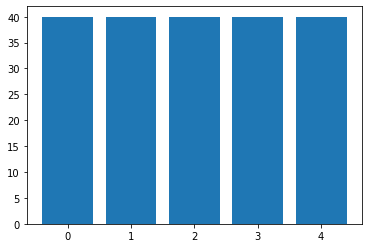

In [ ]:
counter = Counter(y_smote)
for k,v in counter.items():
    per = v / len(y_smote) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

In [ ]:
data_svm

In [ ]:
desc_test_rm_regex

In [ ]:
desc_test_rm_stopword